In [ ]:
# import library 
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
import shutil
import pandas as pd
import csv 


# Split data 

In [ ]:
# set parameters

# Set the desired dimensions for the images
width = 1600
height = 2000

In [ ]:
def preprocess_page(dir_path, width, height, output_dir):
  # Loop through all files in the input directory
  for filename in os.listdir(dir_path):
    # Get the full path of the file
    filepath = os.path.join(dir_path, filename)
    # Check if the file is an image
    if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
      # Load the image
      img = Image.open(filepath)
      # Resize the image to the desired dimensions
      img = img.resize((width, height))
      # Convert the image to grayscale
      img = img.convert('L')
      # Save the resized image to the output directory
      img.save(os.path.join(output_dir, filename))
  return output_dir



In [ ]:
def frame_extraction(input_dir, output_dir):
    
    # Loop through all images in the input directory
    for img_filename in os.listdir(input_dir):
        # Load the image
        img = cv2.imread(os.path.join(input_dir, img_filename))
        
        # Apply Canny edge detection
        edges = cv2.Canny(img, 50, 150, apertureSize=3)
        
        # Find contours in the edges image
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Loop over the contours and filter out the ones that are not frames
        frames = set()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 700 and h > 800: # adjust the minimum width and height to filter out small contours
                aspect_ratio = float(w)/h
                if aspect_ratio > 0.3 and aspect_ratio < 3.0: # adjust the aspect ratio range to filter out non-frame contours
                    frame=(x, y, w, h)
                    if frame not in frames:
                        frames.add(frame)
                        
        # Crop the image to the bounding boxes to extract the frames
        for i, frame in enumerate(frames):
            x, y, w, h = frame
            frame_img = img[y:y+h, x:x+w]
            filename = f'{img_filename.split(".")[0]}_frame_{i}.jpg' # Add the image filename to the frame filename
            cv2.imwrite(os.path.join(output_dir, filename), frame_img)
            
    return output_dir


# Object detection
given an image, return possible IEs

In [ ]:
# 1. installation

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.3 MB/s eta 0:00:00


In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 28.5 MB/s eta 0:00:00


In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

# DETR 
def object_detection(image_file):
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

    image = Image.open(image_file).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.8
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

    detected_objects = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      detected_objects.append({
          "class_name": model.config.id2label[label.item()],
          "bbox": box
          })
    return detected_objects


In [ ]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection

# YOLO
def object_detection_YOLO(image_file):

    processor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-tiny')
    model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')

    image = Image.open(image_file).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.8
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

    detected_objects = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      detected_objects.append({
          "class_name": model.config.id2label[label.item()],
          "bbox": box
          })
    return detected_objects

# OCR
given an image, return possible TEs

*   use Paddle to extract sentence from speech bubble 




In [ ]:
# installation 
!pip install paddlepaddle==2.4.1 -i https://pypi.tuna.tsinghua.edu.cn/simple
import paddle
paddle.utils.run_check()
!pip install "paddleocr>=2.0.1" 
!pip install nltk
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery 3.9.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle works well on 2 CPUs.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


/usr/local/lib/python3.10/dist-packages/paddle/fluid/executor.py:1583: UserWarning: Standalone executor is not used for data parallel
  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:16<00:00, 243kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:19<00:00, 512kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:14<00:00, 147kiB/s]

[2023/05/11 10:23:59] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/usr/local

In [ ]:
def OCR (frame):
  frame = Image.open(frame)
  all_texts = []
  img_np = np.array(frame)
  text = ocr.ocr(img_np, cls=True)
  new_result=text[0]
  texts = [line[1][0] for line in new_result]
  all_texts.extend(texts)
  sentence=" ".join(all_texts)
  sentence = sentence.replace("'", '')
  return sentence

In [ ]:
import logging

# Disable debug messages from ppocr logger
logging.getLogger('ppocr').setLevel(logging.WARNING)

# TE retrieval 

1. retrieve nouns (TE1)
2. named entity recognition (TE2) 
3. nouns + named entity recognition + external dataset (TE3)



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download necessary data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def TE1(sentence):
  # Remove punctuation characters

  #translator = str.maketrans('', '', string.punctuation)
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  text = sentence.translate(translator)

  # Tokenize the text into individual words
  words = word_tokenize(text)
  word_list = [word.lower() for word in words]
  # Remove stop words such as "is," "an," and "which"
  filtered_words = [word for word in word_list if word not in stopwords.words("english")]
  # Extract only the nouns from the text
  nouns = [word.title() for (word, pos) in nltk.pos_tag(filtered_words) if pos[:2] == "NN"]

  return nouns

In [ ]:
TE1('AS THE HUGE BOMBER TOUCHED DOWN, THE LANDING GEAR CRUMPLED. WITH A SHRIEK OF TORTURED METAL IT SKIDDED ON ITS BELLY ALONG THE RUNWAY, SPARKS SHOWERING INTO THE GREY MORNING,AS THE HUGE BOMBER TOUCHED DOWN, THE LANDING GEAR CRUMPLED.')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import torch

ner_pipeline = pipeline("ner", model="dbmdz/electra-large-discriminator-finetuned-conll03-english", tokenizer="dbmdz/electra-large-discriminator-finetuned-conll03-english")

def TE2(sentence):
    named_ents = ner_pipeline(sentence)

    filtered_list = []
    i = 0
    while i < len(named_ents):
        if named_ents[i]['score'] > 0.8:
            word = named_ents[i]['word']
            i += 1
            while i < len(named_ents) and named_ents[i]['index'] == named_ents[i-1]['index'] + 1:
                word += ' ' + named_ents[i]['word']
                i += 1
            word = word.replace('##', '')  # remove special characters
            filtered_list.append(word.title())
        else:
            i += 1
    
    return filtered_list

In [ ]:
TE2('HOSTILE AIRCRAFT 57 WAS NO ORDINARY GERMAN PLANE. IN THE COCKPIT SAT FLIEGER LEUTNANT FRANZ VON STEIN - THE BLACK ACE - PROUD, CONCEITED - HERO OF THE LUFTWAFFE. ON THE BLACK FUSELAGE ON HIS FW. 190 WAS EMBLAZONED AN ACE OF SPADES - THE CARD OF DEATH')

['German', 'Franz Von Stein', 'Luftwaffe', 'F W . 190']

In [ ]:
def TE2_3(sentence):
    # translate the sentence into proper case (capitalize the first letter)
    named_ents = ner_pipeline(sentence)

    filtered_list = []
    i = 0
    while i < len(named_ents):
        if named_ents[i]['score'] > 0.8 and named_ents[i]['entity'] != 'I-PER':
            word = named_ents[i]['word']
            i += 1
            while i < len(named_ents) and named_ents[i]['index'] == named_ents[i-1]['index'] + 1:
                word += '' + named_ents[i]['word']
                i += 1
            word = word.replace('##', '')  # remove special characters
            filtered_list.append(word.title())
        else:
            i += 1
    
    return filtered_list



In [ ]:
TE2_3('HOSTILE AIRCRAFT 57 WAS NO ORDINARY GERMAN PLANE. IN THE COCKPIT SAT FLIEGER LEUTNANT FRANZ VON STEIN - THE BLACK ACE - PROUD, CONCEITED - HERO OF THE LUFTWAFFE. ON THE BLACK FUSELAGE ON HIS FW. 190 WAS EMBLAZONED AN ACE OF SPADES - THE CARD OF DEATH,')

['German', 'Luftwaffe', 'Fw.190']

In [ ]:
def TE2_1(sentence):
    # translate the sentence into proper case (capitalize the first letter)
    sentence = sentence.title()
    named_ents = ner_pipeline(sentence)

    filtered_list = []
    i = 0
    while i < len(named_ents):
        if named_ents[i]['score'] > 0.8 and named_ents[i]['entity'] == 'I-MISC':
            word = named_ents[i]['word']
            i += 1
            while i < len(named_ents) and named_ents[i]['index'] == named_ents[i-1]['index'] + 1:
                word += '' + named_ents[i]['word']
                i += 1
            word = word.replace('##', '')  # remove special characters
            filtered_list.append(word.title())
        else:
            i += 1
    
    return filtered_list


In [ ]:
# external dataset from kaggle 

def csv_2_lst(csv_file):
    with open(csv_file, 'r', encoding='ISO-8859-1') as file:
        reader = csv.DictReader(file)
        # Iterate over each row and extract the country column
        lst = []
        for row in reader:
            l = row['Name']
            lst.append(l)
        # Remove punctuation and whitespace from each word in the list
        list_clean = [''.join(char for char in word if char not in string.punctuation and not char.isspace()) for word in lst]
    return list_clean


upload the three csv files from Kaggle 

In [ ]:
# aircraft=csv_2_lst('Aircraft.csv')
# ships=csv_2_lst('ships.csv')
# vehicles=csv_2_lst('vehicles.csv')

In [ ]:
def TE3(sentence, class_name):
    TE_1 = TE1(sentence)
    TE_2 = TE2(sentence)
    
    # Check if either TE1 or TE2 is None
    if TE_1 is None or TE_2 is None:
        return []
    
    filtered_list = TE_1 + TE_2
    clean_list = [word.lower().translate(str.maketrans('', '', string.punctuation)) for word in filtered_list]
   
    matching_words = []
    # Based solely on the categories in COCO
    if class_name == "airplane":
        list2 = [word.lower() for word in aircraft]
    elif class_name in ["truck", "bicycle", "car"]:
        list2 = [word.lower() for word in vehicles]
    elif class_name == "boat":
        list2 = [word.lower() for word in ships]
    else:
        # If the class name is not recognized, return an empty list
        return matching_words
    
    sorted_list2 = sorted(list2, key=len, reverse=True) # Sort the list in descending order by length
    
    for word in clean_list:
        for word2 in sorted_list2:
            if word in word2 and word not in matching_words:
                matching_words.append(word.title())
                break
    
    return matching_words




# Similarity measure

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md
import spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-11 10:25:26.533714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
# Load the pre-trained word embedding model
nlp = spacy.load('en_core_web_md')

# compute similarity 
def similarity_measure (target_word, words_to_compare):
  # Compute the vector representation of the target word
  target_vector = nlp(target_word).vector
  
  # Compute the vector representation of each word to compare
  vectors_to_compare = [nlp(word).vector for word in words_to_compare]
  
  # Compute the cosine similarity between the target vector and each vector to compare
  similarities = [np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector)) for vector in vectors_to_compare]
  
  # Find the index of the word with the highest similarity score
  max_index = np.argmax(similarities)
  
  # Get the corresponding word
  most_similar_word = words_to_compare[max_index]

  return most_similar_word

In [ ]:
def similarity_measure_with_threshold(target_word, words_to_compare, threshold):
    # Compute the vector representation of the target word
    target_vector = nlp(target_word).vector

    # Compute the vector representation of each word to compare
    vectors_to_compare = [nlp(word).vector for word in words_to_compare]

    # Compute the cosine similarity between the target vector and each vector to compare
    similarities = [np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector)) for vector in vectors_to_compare]

    # Find the word with the maximum similarity score
    max_similarity = max(similarities)
    most_similar_word = words_to_compare[similarities.index(max_similarity)]

    # If the maximum similarity score is above the threshold, return the most similar word
    if max_similarity >= threshold:
      return most_similar_word
    else:
      return None



In [ ]:
similarity_measure('airplane', ['Grey','Morning','Lancaster','Bomber','Base'])


'Bomber'

# Method 1: Entity pair ranking

In [ ]:
def entity_pair_matching_TE3(panel):
    # OCR 
    sentence = OCR(panel)
    # Get the detected objects
    detected_objects = object_detection(panel)
    if not detected_objects:
      return []

    # Loop over the detected objects
    results = []
    for obj in detected_objects:
        class_name = obj["class_name"]
        if class_name != "person":
            IE = class_name # find the possible IE 
            TE = TE3(sentence, IE) # find the possible TE
            if not TE:
              return []
            most_similar_word = TE[0]
            if not most_similar_word:
                continue
            obj["most_similar_word"] = most_similar_word
            results.append(obj)

    return results

In [ ]:
# entity_pair_matching_TE3('resize/p33.jpg')

In [ ]:
def entity_pair_matching(panel):
    # OCR 
    sentence = OCR(panel)
    TE = TE2(sentence) # find the possible TE (could use TE1, TE2_3, TE2_1)
    if not TE:
        return []
    
    # Get the detected objects
    detected_objects = object_detection(panel) # could change to object_detection_YOLO
    if not detected_objects:
        return []
    
    # Loop over the detected objects
    results = []
    for obj in detected_objects:
        class_name = obj["class_name"]
        if class_name != "person":
            IE = class_name # find the possible IE 
            most_similar_word = similarity_measure(IE, TE) # could change to similarity_measure_with_threshold
            if not most_similar_word:
                continue
            obj["most_similar_word"] = most_similar_word
            results.append(obj)

    return results



In [ ]:
# entity_pair_matching('resize/p05.jpg')

# Result

In [ ]:
# Set the input directories
dir_path = 'Commando'


# create empty folder for resized page level images
output_dir = 'resize'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create empty folder for pre-processed panel level images
frame_dir = 'frame'
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)


In [ ]:
output_dir=preprocess_page(dir_path, width, height, output_dir)

In [ ]:
frame_dir =frame_extraction(output_dir, frame_dir)

In [ ]:
def method_1(image_folder, output_file):
    results_list = []
    for filename in sorted(os.listdir(image_folder)):
        image_path = os.path.join(image_folder, filename)
        # Execute the entity_pair_matching_with_visualization function on the image
        results = entity_pair_matching(image_path)
        # Check if the results are None or empty
        results_list.append(results)
    
    # Create a DataFrame from the results list
    df = pd.DataFrame({'filename': sorted(os.listdir(image_folder)), 'result': results_list})
    # Sort the DataFrame by filename
    df = df.sort_values(by='filename')
    # Reset the index
    df = df.reset_index(drop=True)
    
    # Save the DataFrame as a CSV file
    with open(output_file, 'w') as f:
        df.to_csv(f, index=False)
    
    return df


In [ ]:
# method_1('frame','output.csv') 

# Variation 

1. panel-level and page-level
2. TE1, TE2, TE3 (different TE methods)
3. with/without simiality threshold
4. DETR, YOLO -object detection models (2)
5. named entity recognition: with 4 labels, 1 label (MISC), 3 labels 

# Evaluation

In [ ]:
# process the output csv file 

def add_keyword_column(csv_filename):
    with open(csv_filename, 'r') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)
        header.append('keywords')
        rows = []
        for row in reader:
            keywords = []
            for dictionary in eval(row[1]):
                if 'most_similar_word' in dictionary:
                    keywords.append(dictionary['most_similar_word'])
            row.append(','.join(keywords))
            rows.append(row)
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        writer.writerows(rows)

In [ ]:
# add_keyword_column('output.csv')

In [ ]:
import csv
from collections import Counter

def count_words(filename, column):
    # Open the CSV file
    with open(filename, 'r') as file:

        # Create a CSV reader object
        reader = csv.reader(file)

        # Skip the header row
        next(reader)

        # Count the words in the specified column
        words_counter = Counter()
        for row in reader:
            text = row[column-1] # get the text from the specified column
            words = [word.strip() for word in text.split(',') if word.strip()] # split the text into words using commas, and filter out empty strings
            words_counter.update(words) # count the occurrences of each word

    # Print the total number of occurrences of all words
    total_occurrences = sum(words_counter.values())
    print(f'Total number of occurrences of all words: {total_occurrences}')

    # Print the total number of occurrences of each word
    for word, count in words_counter.items():
        print(f'Word "{word}" occurs {count} times')

    return words_counter


In [ ]:
# count_words('output.csv',3)

# Visualization

In [ ]:

# def entity_pair_matching_with_visualization(panel):
#     # OCR 
#     sentence = OCR(panel)
#     TE = TE2_1(sentence) # find the possible TE
    
#     # Get the detected objects
#     detected_objects = object_detection(panel)

#     # Loop over the detected objects
#     results = []
#     unique_class_names = set()
#     class_name_to_obj = {}
#     for obj in detected_objects:
#         class_name = obj["class_name"]
#         if class_name != "person" and class_name != 'truck':
#             if class_name not in unique_class_names or obj["bbox"][0] > class_name_to_obj[class_name]["bbox"][0]:
#                 unique_class_names.add(class_name)
#                 class_name_to_obj[class_name] = obj

#     for class_name, obj in class_name_to_obj.items():
#         IE = class_name # find the possible IE 
#         most_similar_word = similarity_measure(IE, TE)
#         obj["most_similar_word"] = most_similar_word
#         results.append(obj)

#     # display image
#     img = Image.open(panel)
#     fig, ax = plt.subplots()

#     # Assign a different color to each image and text pair
#     color_map = {}
#     for i, result in enumerate(results):
#         most_similar_word = result["most_similar_word"]
#         if most_similar_word not in color_map:
#             color_map[most_similar_word] = (random.random(), random.random(), random.random())
#         color = color_map[most_similar_word]

#         # Draw the bounding box and add the text label
#         bbox = result["bbox"]
#         ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2))
#         ax.text(bbox[0], bbox[1]-10, most_similar_word, fontsize=10, color=color)

#     ax.imshow(img)
#     ax.axis("off")
#     plt.show()

#     return results



In [ ]:
import random
import matplotlib.pyplot as plt

def entity_pair_matching_with_visualization(panel):
    # OCR 
    sentence = OCR(panel)
    TE = TE2_1(sentence) # find the possible TE
    
    # Get the detected objects
    detected_objects = object_detection(panel)

    # Loop over the detected objects
    results = []
    for obj in detected_objects:
        class_name = obj["class_name"]
        if class_name != "person":
            IE = class_name # find the possible IE 
            most_similar_word = similarity_measure(IE, TE)
            obj["most_similar_word"] = most_similar_word
            results.append(obj)

    # display image
    img = Image.open(panel)
    fig, ax = plt.subplots()

    # Assign a different color to each image and text pair
    color_map = {}
    for i, result in enumerate(results):
        most_similar_word = result["most_similar_word"]
        if most_similar_word not in color_map:
            color_map[most_similar_word] = (random.random(), random.random(), random.random())
        color = color_map[most_similar_word]

        # Draw the bounding box and add the text label
        bbox = result["bbox"]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2))
        ax.text(bbox[0], bbox[1]-10, most_similar_word, fontsize=8, color=color)

    ax.imshow(img)
    ax.axis("off")
    plt.show()

    return results


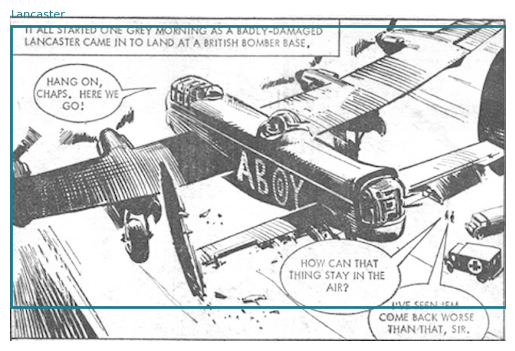

[{'class_name': 'airplane',
  'bbox': [0.16, 13.0, 646.44, 380.0],
  'most_similar_word': 'Lancaster'}]

In [ ]:
entity_pair_matching_with_visualization('frame/11.jpg')